# Planetterp Course Review Data Exploration & NLP Methods
### Spring 2024 Data Science Project (CMSC 320 Final Project)

#### Group Members:
 * Evan Solomon
 * Shreenidhi Ayinala
 * Vasu Mittal

##### Group Github Repo:
https://github.com/ShreenidhiAyinala/CMSC320_FinalProject

###  Member Contribution

**Part A:**

Contribution Checkpoints:<br>
A: Project idea - 5% <br>
B: Dataset Curation and Preprocessing - 10% <br>
C: Data Exploration and Summary Statistics - 10% <br>
D: ML Algorithm Design/Development - 25% <br>
E: ML Algorithm Training and Test Data Analysis - 20% <br>
F: Visualization, Result Analysis, Conclusion - 15% <br>
G: Final Tutorial Report Creation - 10% <br>
H: Additional (not listed above, if any) - 5% <br>

Member 1: Evan Solomon, Contribution: (100%) <br>
Member 2: Shreenidhi Ayinala, Contribution: (100%) <br>
Member 3: Vasu Mittal, Contribution: (100%)<br>

"We, all team members, agree together that the above information is true, and we are confident about our contributions to this submitted project/final tutorial." <br>
**_Evan Solomon 05/07/24_<br>
_Shreenidhi Ayinala 05/07/24_<br>
_Vasu Mittal 05/07/24_**


**Part B:**

Evan Solomon: 
- Delved into the data collected, performed thorough analyses, and generated valuable insights
- Played a crucial role in drafting the project report, ensuring that our conclusions were well-supported by evidence
- Responsible for creating visualizations, charts, and graphs to illustrate our findings effectively

Shreenidhi Ayinala: 
- Responsible for compiling data, conducting literature reviews, and summarizing findings to inform our project
- Took charge of the research phase, diving deep into the topic to gather relevant information and resources

Vasu Mittal: 
- Lead the implementation, putting our ideas into action and developing the practical components of our project
- Responsible for coding, designing prototypes, and testing our solutions to ensure functionality and effectiveness

Overall, our team split the work evenly, with each member contributing their unique strengths and expertise to the project. We maintained open communication, collaborated effectively, and supported each other throughout the process to achieve our goals.


## #1 Introduction
We will be exploring the Planetterp Reviews Data. This data is a collection of numerical ratings
and unstructured text regarding students’ experiences in courses at UMD, College Park.
Source domain: https://planetterp.com/

Analysis of this dataset presents an opportunity to identify and investigate any trends about
student reviews and any relationships that may exist regarding university departments and
student feedback.
Given that we have a date associated with the reviews, we can potentially investigate some
chronological trends.
Finally, the text associated with many of the reviews provides our group the opportunity to learn
about parsing and analyzing text as data.

Given that we are being introduced to data exploration and machine learning methods including NLP in
our CMSC320 course, this project will serve as an opportunity to explore applying
some data exploration methods the course and explore the challenge of applying some
methods that we have only been introduced to conceptually.

In the course of completing this project, we applying the following EDA and ML techniques:

- Web scraping due to collect data
- Data cleaning & feature engineering
- Hypothesis tests to answer the following questions:
- Natural language preprocessing using:
  - Vectorized text data
  - Applying TF-IDF to vectorized data
- Train and Evaluate Logistic Regression Model

## #2 Data Curation
The reviews pages are not a part of the public API, so we scraped the data programmatically
from the reviews pages for all the courses on the site.
An example of a reviews page for the course CMSC420 is available at:
https://planetterp.com/course/CMSC420/reviews
##### Features of the data:
Each record is of a review left by a student, and it contains the following information/features:
- Date that the review was made
- Course Department and Number (e.g. CMSC320)
- Star rating out of 5 stars (i.e. a ‘top’ rating would be 5 stars, and the lowest rating is 1
star)
- Professor name
- Grade that the student received or is expecting to receive
- Review text – unstructured text that the reviewer can use to supplement their review

##### Size of the Data:
There are approximately 26,000 records that we collected. To the best of our knowledge, this
represents the totality of all the reviews at Planetterp.com

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import re
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
course_reviews_data = pd.read_csv("2024_02_21_all_reviews",index_col = 0)
df = pd.DataFrame(course_reviews_data)

#### Peek at the data

In [5]:
df.head()

,course_code,status_code,star_count,prof_name,prof_slug,grade,reviewer_name,date,review_text,review_id
0,NFSC112,200,4,Abani Pradhan,/professor/pradhan,Expecting an A,Anonymous,12/23/2023,"Didn't learn anything, but didn't need to. Eas...",review-31256
1,NFSC112,200,5,Qin Wang,/professor/wang_qin,Expecting an A,Anonymous,12/18/2023,Easy class. The lectures are asynchronous but ...,review-30485
2,NFSC112,200,5,Xiaoxue Jia,/professor/jia_xiaoxue,Expecting an A,Anonymous,12/13/2023,She is amazing with ADS and helpful with answe...,review-29852
3,NFSC112,200,2,Abani Pradhan,/professor/pradhan,Expecting a B-,Anonymous,12/06/2023,Easy class as long as you actually watch the l...,review-28855
4,NFSC112,200,5,Qin Wang,/professor/wang_qin,Expecting an A,Anonymous,11/26/2023,"she is a good lecturer, nfsc 112, is ""chill,"" ...",review-28192


#### Preprocessing

In [6]:
# extract dept and course_num using a regular expression
df[['dept', 'course_num']] = df['course_code'].str.extract('([A-Z]{4})([0-9]+[A-Z]*)', expand=True)

# rename grade => expected_grade
df = df.rename(columns={"grade": "expected_grade"})

# convert date => datetime, and add month, year cols
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.to_period('M')

def date_to_year_finder(date):
  return date.year

new_year_df = df['date'].apply(date_to_year_finder)
df['year'] = new_year_df

# drop status_code, prof_slug, review_id, and course_code
df = df.loc[:, ~df.columns.isin(['status_code', 'prof_slug','review_id'])]

# convert star_count to numeric
df['star_count'] = pd.to_numeric(df['star_count'])

# dropping duplicates
df.drop_duplicates(inplace=True)

In [7]:
# clean up expected grades
# map letter grades to numeric
df['expected_grade'] = df['expected_grade'].str.extract('(Expecting a[n]? )([A-z0-9\-?+]{1,2})', expand=True)[1]
df.expected_grade = df.expected_grade.str.upper()

grade_mapper = {
    "A+":4.0,
    "A":4.0,
    "AA":4.0,
    "A?":4.0,
    "A-":3.7,
    "-A":3.7,
    "B+":3.3,
    "B":3.0,
    "B?":3.0,
    "B-":2.7,
    "BC":2.5,
    "CB":2.5,
    "C+":2.3,
    "C":2.0,
    "C?":2.0,
    "C-":1.7,
    "CD":1.5,
    "D+":1.3,
    "D":1.0,
    "D-":0.7,
    "F":0,
    "F+":0,
    "XF":0,
    "P":None,
    "S":None,
    "I":None,
    "-":None,
    "AU":None,
    "??":None,
    "?":None,
    "W":None
}

def map_grades_to_gpa(letter_grade):
    if pd.isna(letter_grade) or letter_grade == np.nan :
        return None
    else:
        if letter_grade.isnumeric():
            return None
        elif ( letter_grade in grade_mapper.keys()):
            return grade_mapper[letter_grade]
        else:
            print("Not in mapper: " +letter_grade)
            return None

df['gpa_grade'] = df['expected_grade'].apply(map_grades_to_gpa)


In [8]:
# adding a new term feature to our dataframe for analysis

term_mapper = {
    2: "Spring",
    3: "Spring",
    4: "Spring",
    6: "Summer",
    7: "Summer",
    9: "Fall",
    10: "Fall",
    11: "Fall",
}

def date_to_term_finder(date):
    month = date.month
    day = date.day
    if (month == 5 and day <= 20) or (month == 1 and day > 20):
        term = "Spring"
    elif (month == 5 and day > 20) or (month == 8 and day <= 20):
        term = "Summer"
    elif (month == 8 and day > 20) or (month == 12 and day <= 20):
        term = "Fall"
    elif month == 12 and day > 20 or (month == 1 and day <= 20):
        term = "Winter"
    else:
        term = term_mapper.get(month, "Unknown")
    return term

new_terms_df = df['date'].apply(date_to_term_finder)
df['term'] = new_terms_df

In [9]:
# adding a new level feature to our dataframe to determine the level of
# our course for the purpose of the analysis

def course_level_finder(course_code):
    course_level_pattern = r'([0-9]{3})[A-Z]?'
    course_regex = re.compile(course_level_pattern)
    course_level_match = course_regex.search(course_code)
    if course_level_match:
        course_level = int(course_level_match.group(1))
        if course_level >= 100 and course_level < 200:
            return 100
        elif course_level >= 200 and course_level < 300:
            return 200
        elif course_level >= 300 and course_level < 400:
            return 300
        elif course_level >= 400 and course_level < 500:
            return 400
        elif course_level >= 500 and course_level < 600:
            return 500
        elif course_level >= 600 and course_level < 700:
            return 600
        elif course_level >= 700 and course_level < 800:
            return 700
        else:
            return 800
df_cmsc = df.copy()
df_cmsc.loc[:, 'level'] = df['course_num'].apply(course_level_finder)
df = df_cmsc

In [10]:
#introducting a new gpa_category feature for analysis purpose
# 1) 0.0 - 2.8 : 1
# 2) 2.8 - 3.7 : 2
# 3) 3.8 - 4.0 : 3

# We have taken these to be our way of defining categories to try and reduce the class imbalance. Our data is highly skewed towards higher GPA's causing
# the 50th and the 75th percentile to be the same and so it was determined that having arbitrary ranges is a better option.

def gpa_grade_to_category(gpa_grade):
    if gpa_grade >= 0.0 and gpa_grade <= 2.8:
        return 1
    elif gpa_grade > 2.8 and gpa_grade <= 3.6:
        return 2
    elif gpa_grade > 3.6 and gpa_grade <= 4.0:
        return 3


updated_df_cmsc = df.copy()
updated_df_cmsc.loc[:,'gpa_category'] = df['gpa_grade'].apply(gpa_grade_to_category)
df = updated_df_cmsc

#### Peek after cleaning / feature engineering

In [11]:
df.head(5)

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,month,year,gpa_grade,term,level,gpa_category
0,NFSC112,4,Abani Pradhan,A,Anonymous,2023-12-23,"Didn't learn anything, but didn't need to. Eas...",NFSC,112,2023-12,2023,4.0,Winter,100,3.0
1,NFSC112,5,Qin Wang,A,Anonymous,2023-12-18,Easy class. The lectures are asynchronous but ...,NFSC,112,2023-12,2023,4.0,Fall,100,3.0
2,NFSC112,5,Xiaoxue Jia,A,Anonymous,2023-12-13,She is amazing with ADS and helpful with answe...,NFSC,112,2023-12,2023,4.0,Fall,100,3.0
3,NFSC112,2,Abani Pradhan,B-,Anonymous,2023-12-06,Easy class as long as you actually watch the l...,NFSC,112,2023-12,2023,2.7,Fall,100,1.0
4,NFSC112,5,Qin Wang,A,Anonymous,2023-11-26,"she is a good lecturer, nfsc 112, is ""chill,"" ...",NFSC,112,2023-11,2023,4.0,Fall,100,3.0


## #3 Exploratory Data Analysis:

#### Questions about the data that we explore:
1. Is there a difference in the distribution of the ratings students give courses, between the groups of students who expect to receive an A, and those who expect to recieve a lower grade?
2. Is there a significant difference in mean GPA across different levels of CS courses and different years?
3. Is there a difference between the mean number of stars between anonymous versus non-anonymous users?

#### General investigation of basic trends in the dataset:

Summary statistics on different features within our new updated dataframe

In [12]:
df['gpa_grade'].describe()

count    21779.000000
mean         3.627347
std          0.622387
min          0.000000
25%          3.300000
50%          4.000000
75%          4.000000
max          4.000000
Name: gpa_grade, dtype: float64

In [13]:
df['term'].describe()

count     26124
unique        4
top        Fall
freq      10520
Name: term, dtype: object

In [14]:
df[["star_count", "gpa_grade"]].describe()

,star_count,gpa_grade
count,26124.000000,21779.000000
mean,3.735263,3.627347
std,1.496427,0.622387
min,1.000000,0.000000
25%,3.000000,3.300000
50%,4.000000,4.000000
75%,5.000000,4.000000
max,5.000000,4.000000


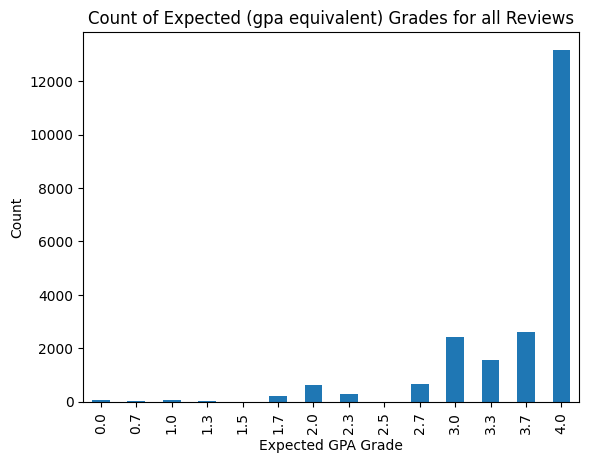

In [15]:
df['gpa_grade'].value_counts().sort_index().plot(kind="bar", title="Count of Expected (gpa equivalent) Grades for all Reviews")
plt.xlabel('Expected GPA Grade')
plt.ylabel('Count')
plt.show()

We can see in the above chart, that the students who expect that they will receive a good grade, make up the vast majority of all students who leave reviews.

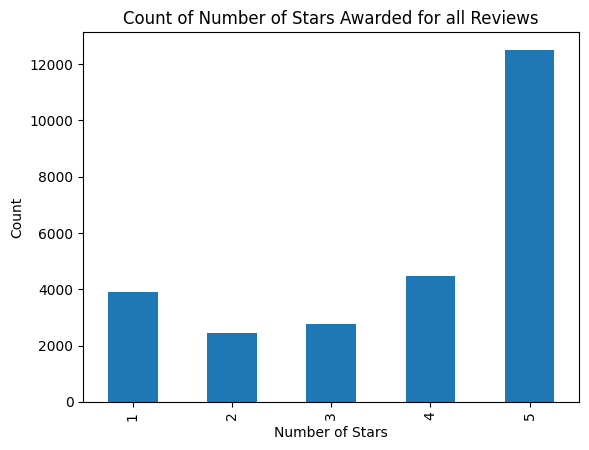

In [16]:
df.star_count.value_counts().sort_index().plot(kind="bar", title="Count of Number of Stars Awarded for all Reviews")
plt.xlabel('Number of Stars')
plt.ylabel('Count')
plt.show()

The chart above shows that most of the star ratings that students give to courses fall in the 5 star category, with a more even distribution for 0 to 4 stars.

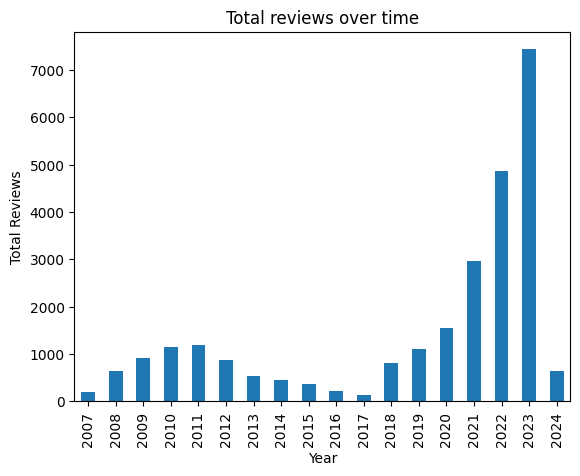

In [17]:
df.groupby('year').size().plot(kind="bar", title="Total reviews over time")
plt.xlabel('Year')
plt.ylabel('Total Reviews')
plt.show()

The chart above shows how the annual number of planetterp reviews has continuously, and significantly increased starting in 2021.

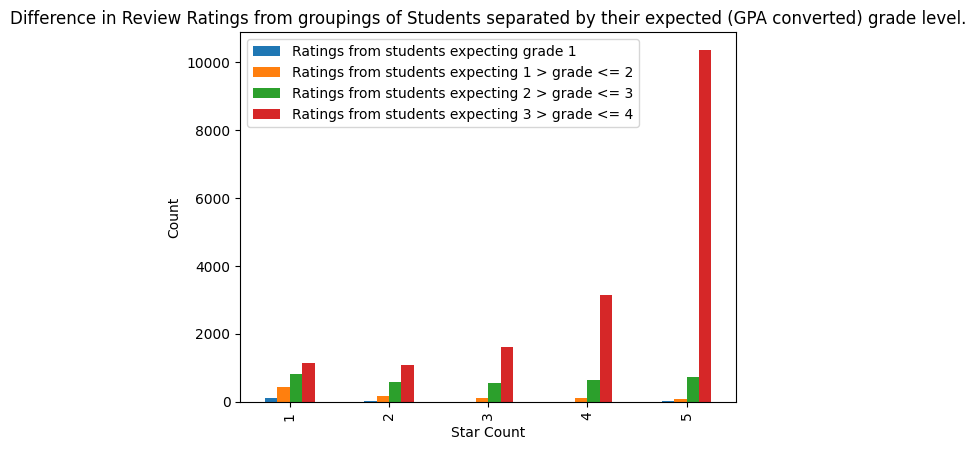

In [18]:
ratings_from_grade_earners_lte_1 = pd.Series(df[df["gpa_grade"] <= 1]["star_count"].value_counts().sort_index(),name="Ratings from students expecting grade 1")
ratings_from_grade_earners_gt_1_lte_2 = pd.Series(df[(df["gpa_grade"] > 1) & (df["gpa_grade"] <= 2)]["star_count"].value_counts().sort_index(),name="Ratings from students expecting 1 > grade <= 2")
ratings_from_grade_earners_gt_2_lte_3 = pd.Series(df[(df["gpa_grade"] > 2) & (df["gpa_grade"] <= 3)]["star_count"].value_counts().sort_index(),name="Ratings from students expecting 2 > grade <= 3")
ratings_from_grade_earners_gt_3_lte_4 = pd.Series(df[(df["gpa_grade"] > 3) & (df["gpa_grade"] <= 4)]["star_count"].value_counts().sort_index(),name="Ratings from students expecting 3 > grade <= 4")

crosstab_four_groups = pd.concat([
    ratings_from_grade_earners_lte_1,
    ratings_from_grade_earners_gt_1_lte_2,
    ratings_from_grade_earners_gt_2_lte_3,
    ratings_from_grade_earners_gt_3_lte_4
], axis=1)
crosstab_four_groups.plot(kind="bar", title="Difference in Review Ratings from groupings of Students separated by their expected (GPA converted) grade level.")
plt.xlabel('Star Count')
plt.ylabel('Count')
plt.show()

For the chart above, we have grouped reviewers into four groups based on their expected (GPA converted) grade. This chart indicates that the students expecting higher grades overwhelmingly are giving courses higher ratings (5 and 4 star ratings).

Out of curiosity, let's see the five most reviewed departments by year

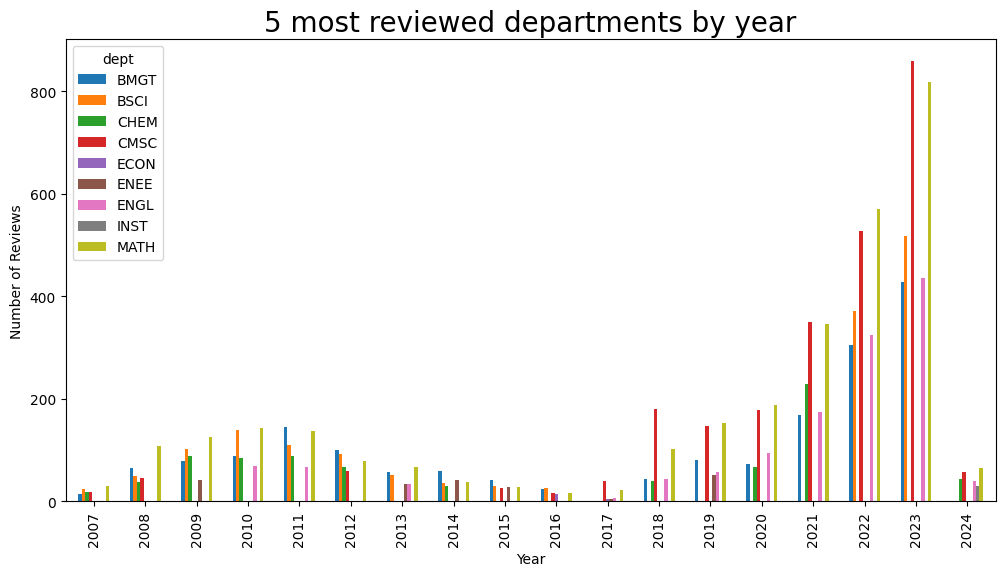

In [19]:
# 5 most reviewed departments by year
num_ratings_per_year_per_dept = df.groupby(["year"])["dept"].value_counts()
five_most_rated_depts_by_year = num_ratings_per_year_per_dept.groupby(level=0, group_keys=False).nlargest(5)

ax = five_most_rated_depts_by_year.reset_index(name="count")\
    .pivot_table(values="count", index="year", columns="dept")\
    .plot(
        kind="bar",
        figsize=(12, 6),
        title="5 most reviewed departments by year",
        width=0.6
    )

ax.set_xlabel('Year')
ax.set_ylabel('Number of Reviews')
ax.title.set_size(20)
plt.show()

Seeing the rise in the popularity of the CMSC department we were curious to explore some CS department specific trends within our dataset. To achieve this purpose we are instantiating a new dataframe that will be used in trend depiction as well as for the purpose of analysis

In [20]:
df_cmsc = df[df['dept'] == 'CMSC']

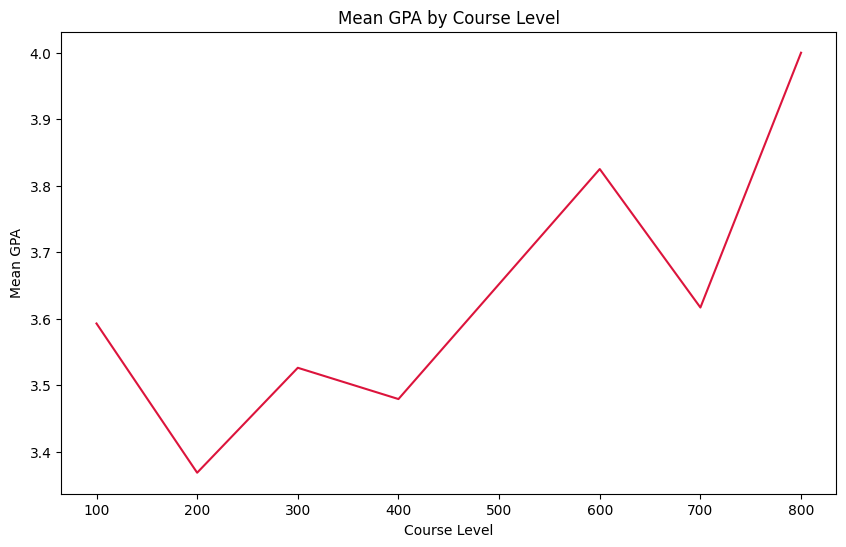

In [21]:
mean_gpa_by_level = df_cmsc.groupby('level')['gpa_grade'].mean()

plt.figure(figsize=(10, 6))
mean_gpa_by_level.plot(kind='line', color='crimson')
plt.title('Mean GPA by Course Level')
plt.xlabel('Course Level')
plt.ylabel('Mean GPA')
plt.xticks(rotation=0)
plt.show()

It is interesting to see how there are sharp falls and rise in the visualization above. This may be occuring either due to the presence of an outlier or potentially insufficient data records.

We can try and determine the reason behind this next!

In [22]:
df_cmsc['level'].value_counts().sort_index(level='level')

level
100    678
200    641
300    567
400    786
600      4
700     14
800      5
Name: count, dtype: int64

Our hunch behind the sharp rise and falls wihtin our line graph was correct! As we can clearly see there's a huge difference in the number of field rows for the 600,700, and 800 level courses in the CMSC department.

<Figure size 1200x600 with 0 Axes>

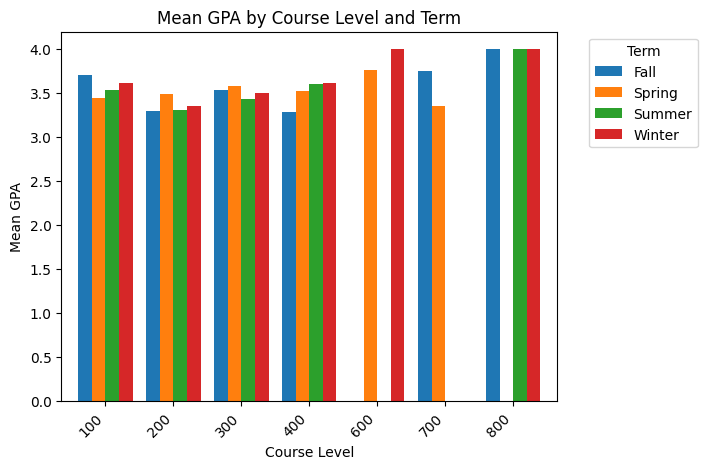

In [23]:
pivot_table = df_cmsc.pivot_table(values='gpa_grade', index='level', columns='term', aggfunc='mean')

plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', width=0.8)
plt.title('Mean GPA by Course Level and Term')
plt.xlabel('Course Level')
plt.ylabel('Mean GPA')
plt.legend(title='Term', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()

The above chart highlights the GPA trends across different levels of CS courses in every term. It is interesting to see how the levels are surprisingly stable and more or less similar across each term

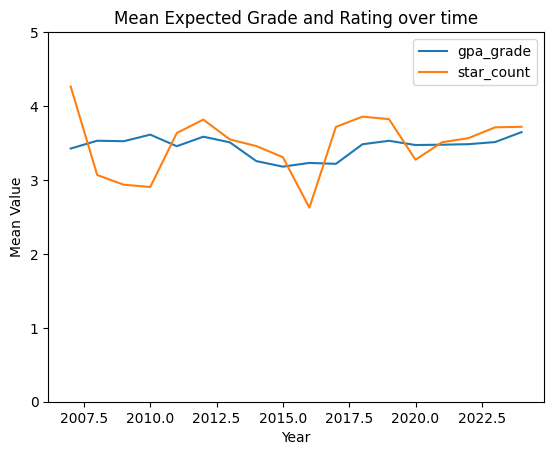

In [24]:
df_cmsc.groupby('year')[['gpa_grade','star_count']].mean().plot(title="Mean Expected Grade and Rating over time", ylim=[0,5])
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.show()

The reviewers' expected grades and course ratings appear relatively steady over time.

### Hypothesis Test 1

#### Question:
Is difference in ratings from higher scoring students and less high scoring students, hinted at in the chart above, also reflected in the results of a chi-squared test?

A grade of an A or A- translate to a grade score of >= 3.7, so we will segment reviewers into two groups that fall on either side of the A- threshold.

In [25]:
greater_than_eq_3pt7 = pd.Series(df[df["gpa_grade"] >= 3.7]["star_count"].value_counts().sort_index(),name="Ratings from Students Expecting As")
less_than_3pt7 = pd.Series(df[df["gpa_grade"] < 3.7]["star_count"].value_counts().sort_index(),name="Ratings from Students Expecting less than As")

crosstab = pd.concat([greater_than_eq_3pt7,less_than_3pt7], axis=1)
crosstab

,Ratings from Students Expecting As,Ratings from Students Expecting less than As
star_count,,
1,909,1605
2,885,983
3,1360,923
4,2790,1126
5,9846,1352


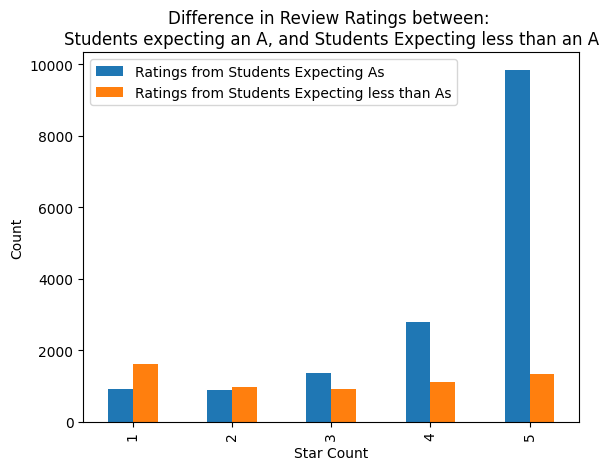

In [26]:
crosstab.plot(kind="bar", title="Difference in Review Ratings between: \nStudents expecting an A, and Students Expecting less than an A")
plt.xlabel('Star Count')
plt.ylabel('Count')
plt.show()

The difference in the distribution of star ratings is visually even more stark with just two groups of reviewers.

Null and alternative hypotheses:<br>
**H0: the distribution of course ratings (star count) is the same for the groups of:**
- students who are expecting an A- or higher
- students who are expecting less than an A-

**HA: the distribution of course ratings (star_count) is different for the two groups.**
##### Assume alpha of .05

In [27]:
stats.chi2_contingency(crosstab)

Chi2ContingencyResult(statistic=3787.9709815243573, pvalue=0.0, dof=4, expected_freq=array([[1822.67597227,  691.32402773],
       [1354.31929841,  513.68070159],
       [1655.19858579,  627.80141421],
       [2839.1404564 , 1076.8595436 ],
       [8118.66568713, 3079.33431287]]))

#### Result:
Our p-value from the chi-squared test is near 0 and less than our alpha, therefore, we reject the null hypothesis.
The data indicate a statistically significant difference in the rating distributions between the two groups.

### Hypothesis Test 2

#### Question:

Is there a significant difference in mean GPA across different levels of CS courses and different years?


Taking into consideration the rise in the popularity of the CMSC department and trends the null and alternative hypothesis were determined to be:

1. Null Hypothesis: There is no significant difference in mean GPA across different levels of CS courses and different years.

2. Alternative Hypothesis: There is a significant difference in mean GPA across different levels of CS courses and different years.


Since there are more than 2 columns involved here it would be best for us to use ANOVA test and the level of significance being assumed for this test analysis is 0.05


It is necessary for the calculation of our p-value that the column under consideration has no duplicate values or records with null values within and so for the purpose of the experiment we won't be considering all such row fields.

In [28]:
df_cmsc_copy = df_cmsc.dropna(subset=['gpa_grade'])
df_cmsc_copy.drop_duplicates(inplace=True)
df_cmsc = df_cmsc_copy

/var/folders/8k/pw_095d94tg6j3w2wl0j_70r0000gn/T/ipykernel_77598/175160242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cmsc_copy.drop_duplicates(inplace=True)


Performing ANOVA analysis

In [29]:
new = ols('gpa_category ~ C(level) * C(year)', data=df_cmsc).fit()
an =  sm.stats.anova_lm(new, typ=2)
an

/Users/evanlsolomon/.pyenv/versions/3.10.1/envs/cmsc320/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '
/Users/evanlsolomon/.pyenv/versions/3.10.1/envs/cmsc320/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/Users/evanlsolomon/.pyenv/versions/3.10.1/envs/cmsc320/lib/python3.10/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 102, but rank is 58
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(level),3.082957,6.0,0.995787,0.418744
C(year),10.177286,17.0,1.160201,0.299741
C(level):C(year),71.709761,102.0,1.362474,0.037183
Residual,1081.536285,2096.0,NaN,NaN


#### Result:

Since on performing ANOVA analysis we notice that our p-value is level than the level of significance i.e. 0.05 we will be rejecting our null hypothesis.

Thus, we can conclude that there is a significant difference in mean GPA across different levels of CS courses with the passage of time

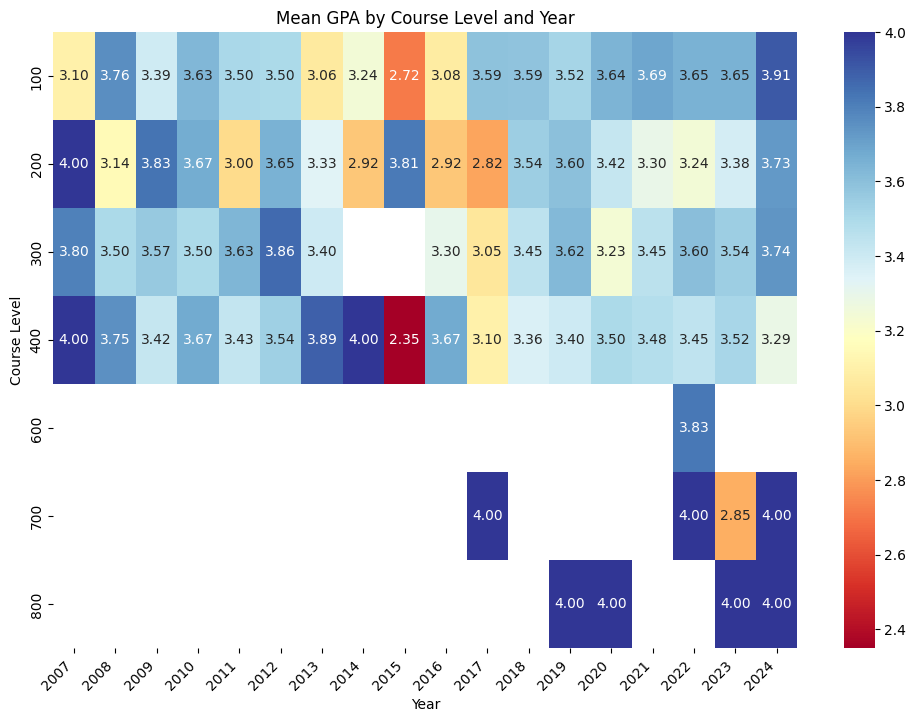

In [30]:
mean_gpa_by_level_year = df_cmsc.groupby(['level', 'year'])['gpa_grade'].mean()
mean_gpa_by_level_year = mean_gpa_by_level_year.unstack()


plt.figure(figsize=(12, 8))
sns.heatmap(mean_gpa_by_level_year, annot=True, fmt=".2f", cmap="RdYlBu")
plt.title('Mean GPA by Course Level and Year')
plt.xlabel('Year')
plt.ylabel('Course Level')
plt.xticks(rotation=45, ha='right')
plt.show()

The chart depicts the variations in the mean GPA amongst the different CMSC department course levels with the passage of time. It may be necessary for us to perform a POST HOC analysis here since it is clearly visible from the visualization and previous findings that the data is scarce for courses starting level 600 which may be potentially affecting our results.

### Hypothesis Test 3:

#### Question:
Is there a difference between the mean number of stars between anonymous versus non-anonymous users?


The null and alternate hypotheses are as follows:<br>
**H0:** The average star count is the same for anonymous and non-anonymous reviewers. <br>
**Ha:** The average star count is not the same for anonymous and non-anonymous reviewers.

_Assume the level of significance is 0.05._

Since we are testing the difference of the true average star count between two populations, it makes the most sense to utilize a two sample t-test.

In [31]:
anonymous_scores = df[df['reviewer_name'] == 'Anonymous']['star_count']
non_anonymous_scores = df[df['reviewer_name'] != 'Anonymous']['star_count']

t_stat, p_value = stats.ttest_ind(anonymous_scores, non_anonymous_scores)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: -10.744572153398497
p-value: 7.1533601785363e-27


#### Result:

We reject the null hypothesis because the p-value of 7.15e-27 is less than the level of significance 0.05. We can conclude that there is a difference between the mean star count of anonymous and non-anonymous reviewers.

The negative ttest that indicates that the anonymous_scores has a lower mean than the non_anonymous scores, indicating that the average star count is higher for non_anonymous_scores.

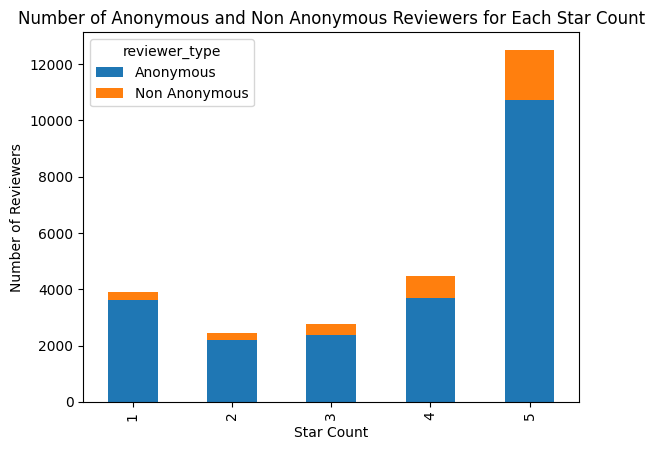

In [32]:
df['reviewer_type'] = df['reviewer_name'].apply(lambda x: 'Anonymous' if x == 'Anonymous' else 'Non Anonymous')
df.groupby(['star_count', 'reviewer_type']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Number of Anonymous and Non Anonymous Reviewers for Each Star Count')
plt.xlabel('Star Count')
plt.ylabel('Number of Reviewers')
plt.show()

This bar graph represents the distribution of star ratings given by anonymous and non-anonymous reviewers. It’s clear that both types of reviewers tend to give higher star counts, with a significant spike at the 5-star rating. This data could be useful for understanding the behavior of different types of reviewers and their rating patterns.

## #4.a Primary Analysis: NLP Model for Predicting Rating Based on Text Review

For the final part of our tutorial, we will explore the feasibility of using the text reviews to predict the star rating. This is a useful exercise for us to gain initial familiarity with text processing and how models can be built on text analysis.

The high-level process we will use for our NLP analysis is:

Prepare the data:
- Split the data into training and testing sets.
- Create a TF-IDF vectorizer to convert the text data into numerical data.
- Train a logistic regression model on the training data, then use the model to predict the star ratings of the reviews in the testing set.
- Use some summary methods like accuracy, and a confusion matrix to evaluate the model
- Evaluate the accuracy of the model on the training and testing sets.


Our first step is to drop the records that do not contain a text review. As you can see below, this leaves us with about 26,000 records.

In [33]:
# Drop records with no reviews
df = df.dropna(subset=['review_text'])
df.shape

(26119, 16)

Let's explore how a logistic regression model performs on predicting the star ratings for all course reviews

In [41]:
# Use logistic regression to predict the star rating of a review based on the review text

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review_text'], df['star_count'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit/Transform the data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create a logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict the star ratings
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate the accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f'Accuracy (Train): {accuracy_train}')
print(f'Accuracy (Test): {accuracy_test}')

# Show the predicted star ratings
print('Predicted Star Ratings:')
print(y_pred_test[:10])

# Show the actual star ratings
print('Actual Star Ratings:')
print(y_test[:10])


Accuracy (Train): 0.7643455372098589
Accuracy (Test): 0.6353369065849923
Predicted Star Ratings:
[1 5 5 1 4 5 5 3 5 5]
Actual Star Ratings:
9480     1
7852     2
14678    5
10975    2
20258    2
18457    5
5160     4
980      3
17531    5
13231    5
Name: star_count, dtype: int64


The accuracy (on test data) of our model at 64% has a lot of room for improvement. Lets inspect the confusion matrix, and the classification report below:

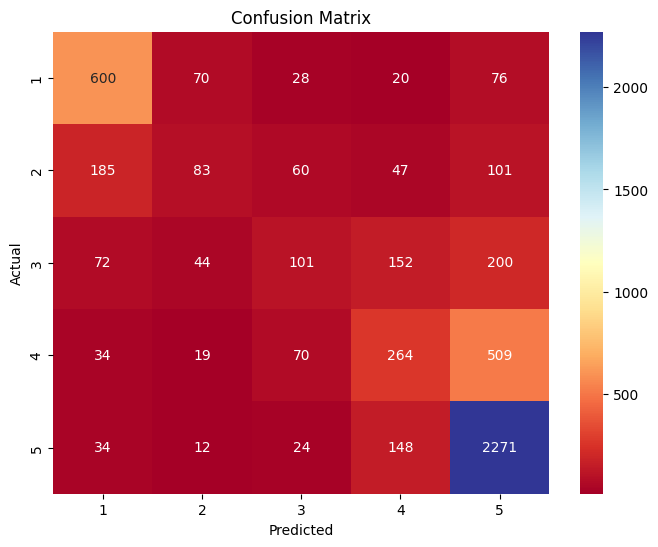

              precision    recall  f1-score   support

           1       0.65      0.76      0.70       794
           2       0.36      0.17      0.24       476
           3       0.36      0.18      0.24       569
           4       0.42      0.29      0.35       896
           5       0.72      0.91      0.80      2489

    accuracy                           0.64      5224
   macro avg       0.50      0.46      0.46      5224
weighted avg       0.59      0.64      0.60      5224



In [42]:
# Show the confusion matrix for the classifier
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Show the classification report
print(classification_report(y_test, y_pred_test))

We can see in the above classification report, that we are predicting the 1 and 5 star reviews significantly better than the 2-4 star reviews.  

Because our model is predicting the class of a multiclass dependent variable as the Star rating, which has a scale of 1-5, we may be more accurate with some classes than with others. 

#### Exploration of How Words Are Processed and Influnce the Model
The main concept with vectorizing documents is that we count the frequency of words in each document, and these frequency vectors then represent the meaning of the document. See below the most common words in our course reviews.

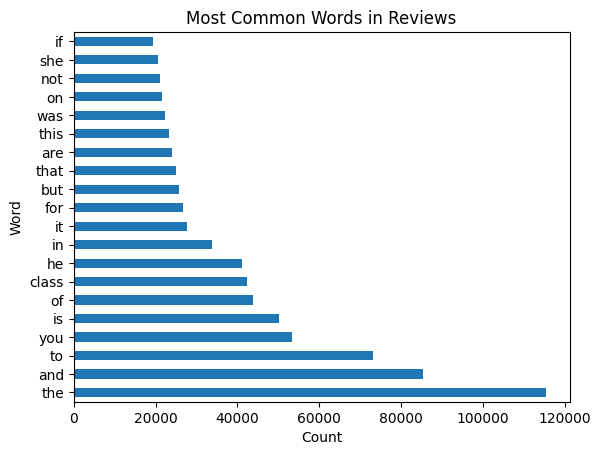

In [43]:
# Create a CountVectorizer object that is aware of english stopwords
vectorizer = CountVectorizer()

#Fit the data to the vector object
X = vectorizer.fit_transform(df['review_text'])

# Create a DataFrame from  to display the most frequent words
df_text = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Display the most frequesnt words
df_text.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Most Common Words in Reviews')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

The words in the above chart may not be what we expected--they are not indicative of review sentiment at all--they are simply a list of the most common words in the english language, mixed with some words specific to our topic. These are called stop words, and if our goal is to predict the star rating, we'll need to have our model exclude these 'stop words' from the analysis.

Let's try reviewing the most common words again--this time, without stop words:

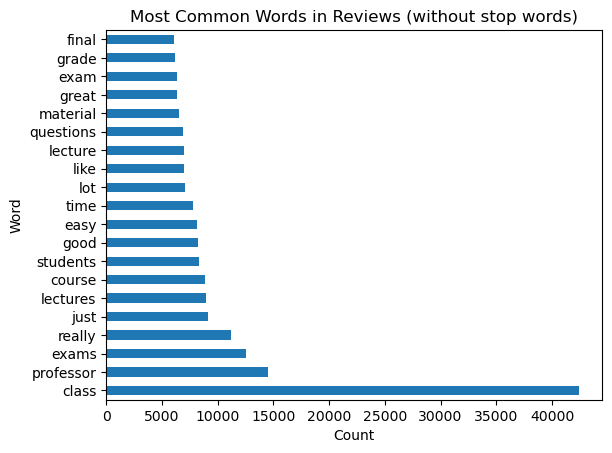

In [309]:
# Create a CountVectorizer object that is aware of english stopwords
vectorizer = CountVectorizer(stop_words="english")

#Fit the data to the vector object
X = vectorizer.fit_transform(df['review_text'])

# Create a DataFrame from  to display the most frequent words
df_text = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Display the most frequesnt words
df_text.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Most Common Words in Reviews (without stop words)')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

This is a big difference. Many of these words are related to a course review, or express sentiment which will improve our model.

Something to note though, words like class and exams may be equally frequent in positive and negative reviews. To address this, we will implement a technique called 'term frequency-inverse document frequency' (TF-IDF) which balances the impact of words relative to their frequency.

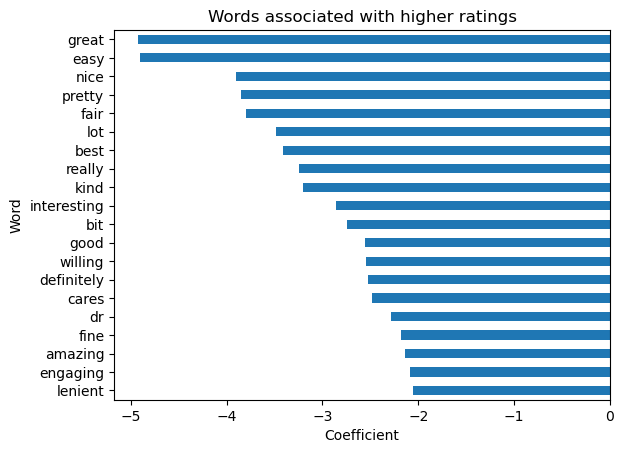

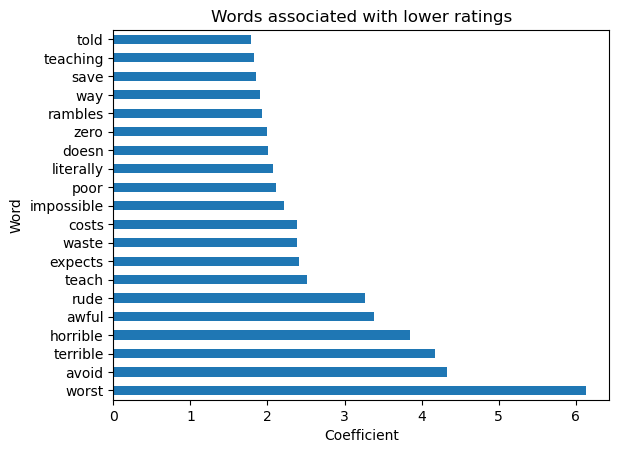

In [310]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review_text'], df['star_count'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Convert the data to pytorch tensors
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)


# Show the regression coefficients
coefficients = pd.Series(model.coef_[0], index=vectorizer.get_feature_names_out())
coefficients.sort_values(ascending=False).tail(20).plot(kind='barh')
plt.title('Words associated with higher ratings')
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.show()

# Show the regression coefficients
coefficients = pd.Series(model.coef_[0], index=vectorizer.get_feature_names_out())
coefficients.sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Words associated with lower ratings')
plt.xlabel('Coefficient')
plt.ylabel('Word')
plt.show()

In the two bar charts above, we can see that our vectorizer has done a good job associating the meaning of words with similar words, as well as the strength of their meaning. For example, 'worst', 'avoid', 'terrible', all have a like effect on our prediction model, and 'great', 'easy', and 'nice', are also evaluated similarly.

## #4.b Secondary Analysis: Predicting Course GPA by analyzing Student Sentiment, and Course Ratings and Levels

In addition to predicting the star count for a course based on the reviews provided by users, as a group, we have decided to conduct further analysis and prediction.

As students, we share various emotions about a given class, and assigning these feelings a scaled numerical value would provide valuable insight to students when determining whether or not to take a course. Additionally, having access to information about the expected GPA range that someone taking the course is anticipating would be useful. With this information, students can make more informed decisions about their course selections.

Therefore, the practical scope of this part of the final tutorial lies in potentially assisting students in making more informed decisions about which courses they wish to enroll in for a given semester. This assistance is provided through the provision of a student sentiment score, as well as information about the expected GPA range that a student may anticipate when taking a course. Both of these factors are important criteria to consider when enrolling in courses.

The high-level process we will use for our analysis is as follows:
- Utilize the **SentimentIntensityAnalyzer** from the **nltk** library.
- Split the data into training and testing sets.
- Train a **Logistic Regression Model** on the training data, then use the model to predict the expected GPA category based on the student sentiment review score, course rating, and course level in the testing set.
- Employ summary methods such as accuracy and a confusion matrix to evaluate the model.
- Assess the accuracy of the model on the training and testing sets.

To kick off things we are going to be removing any null records from our table in the gpa_category section.

In [311]:
df = df.dropna(subset=['gpa_category'])
df.shape

(21776, 16)

Now, we can assign each course a **student_sentiment_score** using the **SentimentIntensityAnalyzer** from the **nltk** library.

Some important points regarding the **SentimentIntensityAnalyzer** are as follows:

- The values returned by this analyzer lie in the range of [-1, 1].
  - -1 indicates a negative sentiment.
  - 0 indicates a neutral sentiment.
  - 1 indicates a positive sentiment.
- This analyzer automatically disregards common words such as **"the"**, **"and"**, **"is"**, and many others.
- This analyzer utilizes the **vader_lexicon** for the purpose of analyzing the sentiment of a given input text.


In [312]:
# Initialize the sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score for each review
def get_sentiment_score(text):
    # Sentiment analysis using NLTK's SentimentIntensityAnalyzer
    sentiment_scores = sentiment_analyzer.polarity_scores(text)
    # Compound score ranges from -1 (most negative) to 1 (most positive)
    return sentiment_scores['compound']

# Apply sentiment analysis function to each review and store the result in a new column
df['sentiment_score'] = df['review_text'].apply(lambda x: get_sentiment_score(x))

In [313]:
df.head(10)

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,month,year,gpa_grade,term,level,gpa_category,reviewer_type,sentiment_score
0,NFSC112,4,Abani Pradhan,A,Anonymous,2023-12-23,"Didn't learn anything, but didn't need to. Eas...",NFSC,112,2023-12,2023,4.0,Winter,100,3.0,Anonymous,-0.5732
1,NFSC112,5,Qin Wang,A,Anonymous,2023-12-18,Easy class. The lectures are asynchronous but ...,NFSC,112,2023-12,2023,4.0,Fall,100,3.0,Anonymous,0.7906
2,NFSC112,5,Xiaoxue Jia,A,Anonymous,2023-12-13,She is amazing with ADS and helpful with answe...,NFSC,112,2023-12,2023,4.0,Fall,100,3.0,Anonymous,0.8398
3,NFSC112,2,Abani Pradhan,B-,Anonymous,2023-12-06,Easy class as long as you actually watch the l...,NFSC,112,2023-12,2023,2.7,Fall,100,1.0,Anonymous,-0.2396
4,NFSC112,5,Qin Wang,A,Anonymous,2023-11-26,"she is a good lecturer, nfsc 112, is ""chill,"" ...",NFSC,112,2023-11,2023,4.0,Fall,100,3.0,Anonymous,0.8782
5,NFSC112,5,Qin Wang,A+,Anonymous,2022-12-28,super chill and easy class... lectures are onl...,NFSC,112,2022-12,2022,4.0,Winter,100,3.0,Anonymous,0.8658
6,NFSC112,4,Qin Wang,A,Anonymous,2022-12-12,"Very chill class, meets once a week for ""discu...",NFSC,112,2022-12,2022,4.0,Fall,100,3.0,Anonymous,0.7027
7,NFSC112,3,Qin Wang,B+,Anonymous,2022-12-11,She's alright. Kinda boring since all she does...,NFSC,112,2022-12,2022,3.3,Fall,100,2.0,Anonymous,0.4841
8,NFSC112,5,Qin Wang,A+,Anonymous,2021-12-31,"Super chill class, do the study guide slides a...",NFSC,112,2021-12,2021,4.0,Winter,100,3.0,Anonymous,0.7430
9,NFSC112,5,Shraddha Karanth,A-,Anonymous,2020-12-04,She's always really prepared for class and not...,NFSC,112,2020-12,2020,3.7,Fall,100,3.0,Anonymous,0.8316


It is important to note that the sentiment score that has been assigned to each of the course here is a representation for a given student's sentiment not only the course but also that particular professor.

Since we are having access to this data now it would be interesting to visualize some interesting trends that may give certain insights to us.

Number of values for each level:
400    627
100    557
200    527
300    450
700      6
600      4
800      4
Name: level, dtype: int64
level
100    0.638752
200    0.465551
300    0.549206
400    0.440681
Name: sentiment_score, dtype: float64


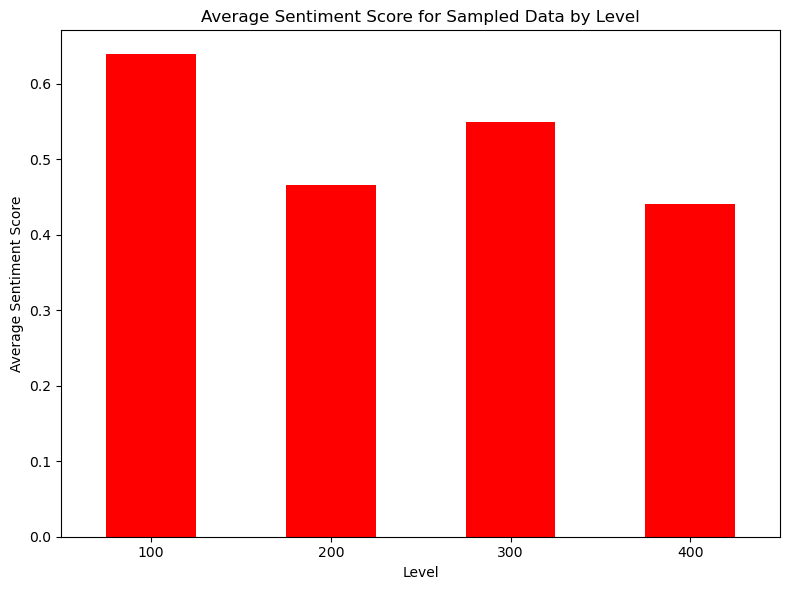

In [314]:
cmsc_df = df[df['dept'] == 'CMSC']

num_values_by_level = cmsc_df['level'].value_counts()
print("Number of values for each level:")
print(num_values_by_level)

sampled_dfs = []

# Sample 450 entries for each level randomly
for level in [100, 200, 300, 400]:
    sampled_df = cmsc_df[cmsc_df['level'] == level].sample(n=450, random_state=42)
    sampled_dfs.append(sampled_df)

# Concatenate the sampled dataframes
sampled_df_combined = pd.concat(sampled_dfs)

# Calculate average sentiment score by level for the sampled data
average_sentiment_by_level_sampled = sampled_df_combined.groupby('level')['sentiment_score'].mean()
print(average_sentiment_by_level_sampled)
# Plot the average sentiment score for CMSC department by level for the sampled data
plt.figure(figsize=(8, 6))
average_sentiment_by_level_sampled.plot(kind='bar', color='red')
plt.title('Average Sentiment Score for Sampled Data by Level')
plt.xlabel('Level')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Since the number of records available are limited for 600,700, and 800 levels the average sentiment score assignned to those levels can be concluded to inaccurate and thus, haven't been displayed in the graph.

As for the remaining levels that share the same number of entries its interesting to notice how the sentiment score is higher for the 300 level classes in comparison to the 200's. We can perform further analysis on the 300 level classes to see which class amongst the 300's has a higher average sentiment score associated with it.

course_num
216     0.453896
216H    0.023500
250     0.421277
250H    0.908045
289I    0.872700
Name: sentiment_score, dtype: float64
course_num
320     0.549531
330     0.647206
335     0.766494
351     0.405751
351H    0.921333
388J    0.943400
389E    0.440400
389I    0.624900
389K    0.735100
389N    0.631395
389O    0.647275
389V    0.771700
389Z   -0.096500
395     0.720633
398D    0.592700
Name: sentiment_score, dtype: float64


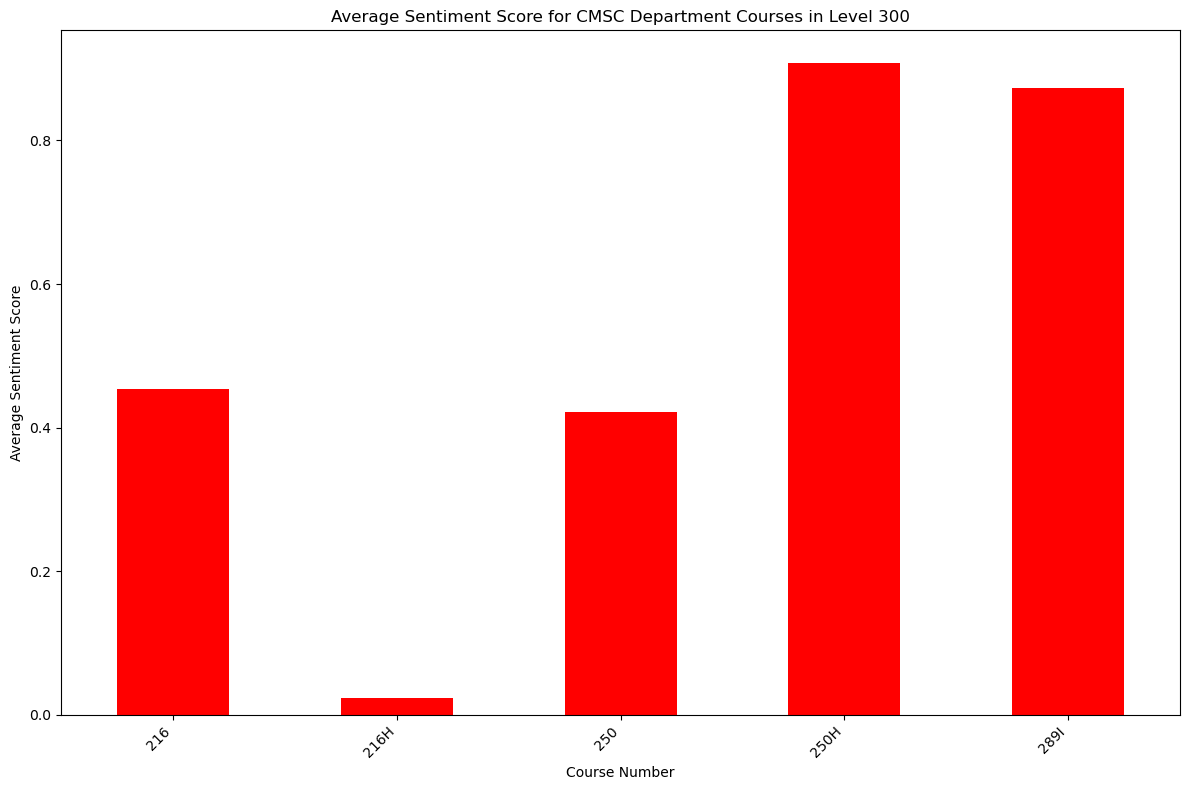

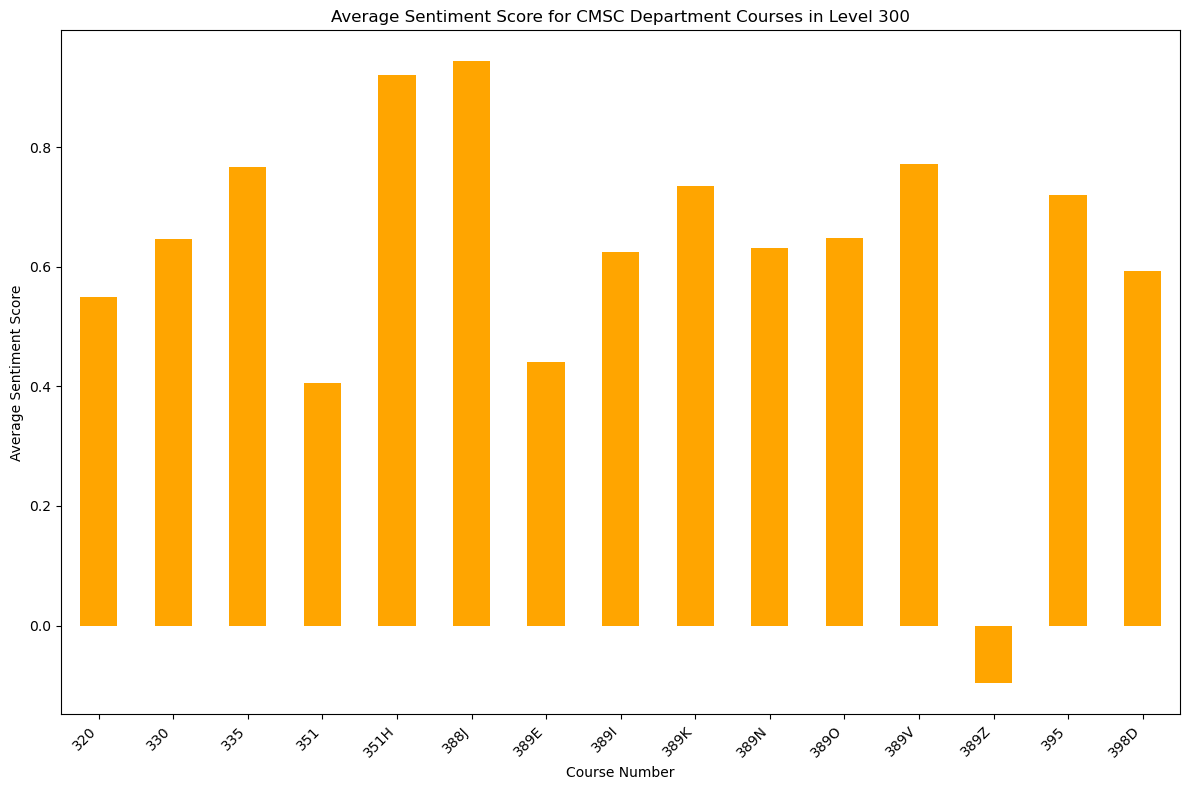

In [315]:
# Filter the dataframe for courses in the 200, 300 level
level_200_courses = cmsc_df[cmsc_df['level'] == 200]
level_300_courses = cmsc_df[cmsc_df['level'] == 300]

# Calculate average sentiment score by course
average_sentiment_by_course_200 = level_200_courses.groupby('course_num')['sentiment_score'].mean()
print(average_sentiment_by_course_200)
average_sentiment_by_course_300 = level_300_courses.groupby('course_num')['sentiment_score'].mean()
print(average_sentiment_by_course_300)
# Plot the average sentiment score for CMSC department courses in the 300 level
plt.figure(figsize=(12, 8))
average_sentiment_by_course_200.plot(kind='bar', color='red')
plt.title('Average Sentiment Score for CMSC Department Courses in Level 300')
plt.xlabel('Course Number')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot the average sentiment score for CMSC department courses in the 300 level
plt.figure(figsize=(12, 8))
average_sentiment_by_course_300.plot(kind='bar', color='orange')
plt.title('Average Sentiment Score for CMSC Department Courses in Level 300')
plt.xlabel('Course Number')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Based off these graphs it will be right to conclude that its due to the number of 300 level courses that are offered at the university that make the overall sentiment score to be higher for 300 level classes.

GPA category ranges are:
Category 1 -> 0.0 <= x <= 2.8
Category 2 -> 2.9 <= x <= 3.7
Category 3 -> 3.8 <= x <= 4.0

Number of points for each GPA category:
3.0    15788
2.0     3981
1.0     2007
Name: gpa_category, dtype: int64


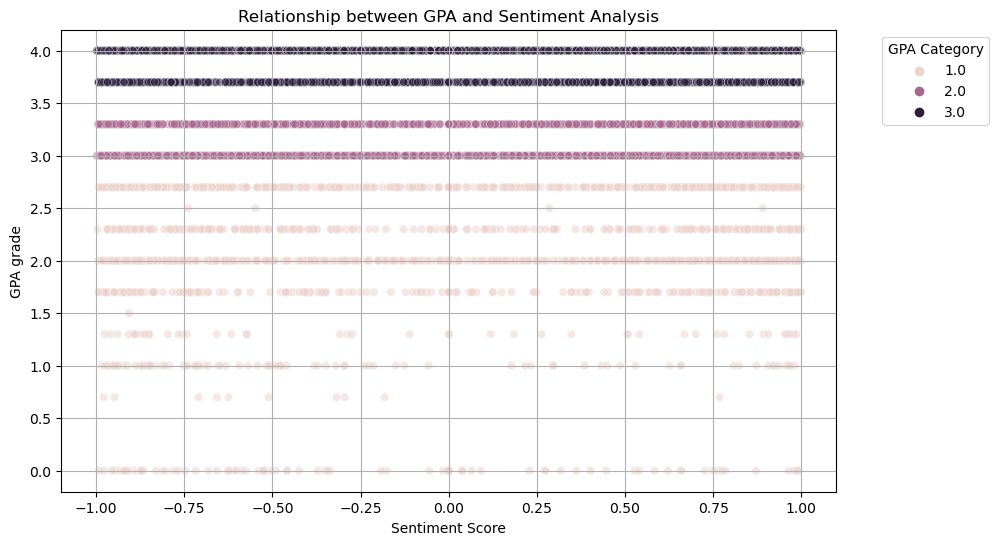

In [316]:
print("GPA category ranges are:")
print("Category 1 -> 0.0 <= x <= 2.8")
print("Category 2 -> 2.9 <= x <= 3.7")
print("Category 3 -> 3.8 <= x <= 4.0")
# Count the number of points for each GPA category
num_points_by_category = df['gpa_category'].value_counts()
print()
# Print the number of points for each GPA category
print("Number of points for each GPA category:")
print(num_points_by_category)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_score', y='gpa_grade', hue='gpa_category', data=df, alpha=0.5)
plt.title('Relationship between GPA and Sentiment Analysis')
plt.xlabel('Sentiment Score')
plt.ylabel('GPA grade')
plt.grid(True)
plt.legend(title='GPA Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


From this scatterplot based on the density of the points it would be right to conclude that most of the users that give a review on the Planetterp platform have a higher GPA in comparison to those who don't. This can also be seen in terms of the datapoints available for the categories specified.

### ***Moving on to the main analysis now***
We are going to perform the analysis using different classification models to determine the best model that would help us model the required relation and classify the required GPA range effectively.

We have chosen **level** and **star_count** as two other important features for this analysis, as in our previous sections we have already demonstrated how these factors can potentially influence GPA.

To identify the best model to use, we will test our data against various classification models and recommend the model that performs the best with the current dataset.

In [317]:
# LogisticRegression model is a linear regression model that is typically used
# in situations wherein our dependent variable is categorical in nature. It is
# usually used for models wherein we have a binary output but can also be used
# for the purpose of

X = df[['level', 'sentiment_score', 'star_count']]
y = df['gpa_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

log_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", log_accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.7284205693296603
              precision    recall  f1-score   support

         1.0       0.46      0.25      0.32       422
         2.0       0.34      0.07      0.12       790
         3.0       0.76      0.96      0.85      3144

    accuracy                           0.73      4356
   macro avg       0.52      0.43      0.43      4356
weighted avg       0.66      0.73      0.66      4356



From the above results, we can conclude that the logistic regression model performs reasonably well, especially in predicting category 3.0. The recall measure for category 3.0 showcases the fact that the model is able to identify the majority of the actual positive values from our data. However, the model does fail to showcase similar results for the remaining 2 categories, which may be attributed to the fact that the number of instances of each of those categories is comparatively less.

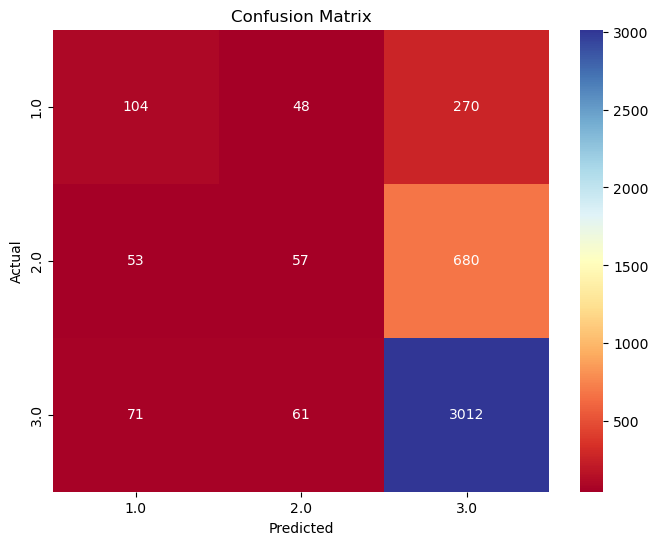

In [318]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu', xticklabels=log_model.classes_, yticklabels=log_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [319]:
X = df[['level', 'sentiment_score', 'star_count']]
y = df['gpa_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

randForest_model = RandomForestClassifier(random_state=42)
randForest_model.fit(X_train, y_train)

y_pred = randForest_model.predict(X_test)

randForest_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", randForest_accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.6368227731864096
              precision    recall  f1-score   support

         1.0       0.26      0.25      0.25       422
         2.0       0.22      0.19      0.20       790
         3.0       0.77      0.80      0.79      3144

    accuracy                           0.64      4356
   macro avg       0.42      0.41      0.42      4356
weighted avg       0.62      0.64      0.63      4356



While the Random Forest Classification Model achieves an accuracy of 64%, it doesn't perform as well as the Logistic Regression Model. A primary reason for this may be the presence of class imbalance in our model, which biases the Random Forest Classification Model toward the majority class, leading to the classification of more points in category 3 than required.

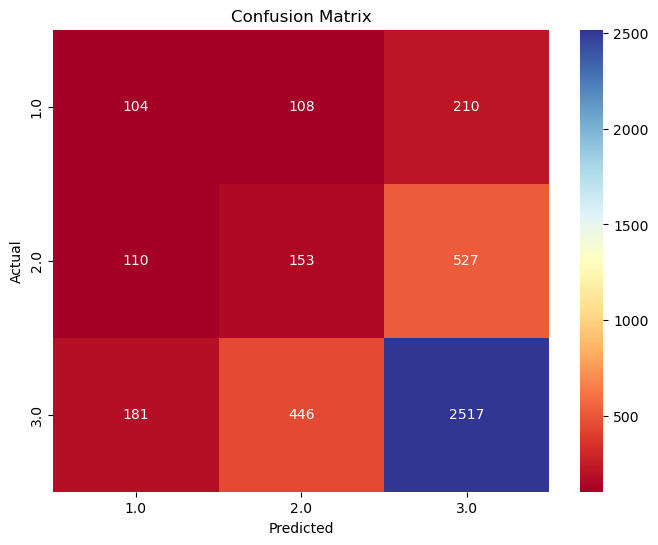

In [320]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu', xticklabels=randForest_model.classes_, yticklabels=randForest_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [321]:
X =  df[['level', 'sentiment_score', 'star_count']]
y = df['gpa_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

svm_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", svm_accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.721763085399449
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       422
         2.0       0.00      0.00      0.00       790
         3.0       0.72      1.00      0.84      3144

    accuracy                           0.72      4356
   macro avg       0.24      0.33      0.28      4356
weighted avg       0.52      0.72      0.61      4356



/Users/ShreenidhiAyinala/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ShreenidhiAyinala/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ShreenidhiAyinala/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

It's intriguing to observe the model's accuracy of 72%, which is remarkably close to that of the regression model. However, it's equally notable that the model categorizes everything as category 3.0, rendering it unsuitable and rendering the accuracy meaningless. It's possible that due to the class imbalance, the model is overfitted and thus classifies everything as category 3.0. Such a model is undesirable, as we aim for the model to naturally classify items by identifying underlying patterns instead of memorizing and learning the outputs.

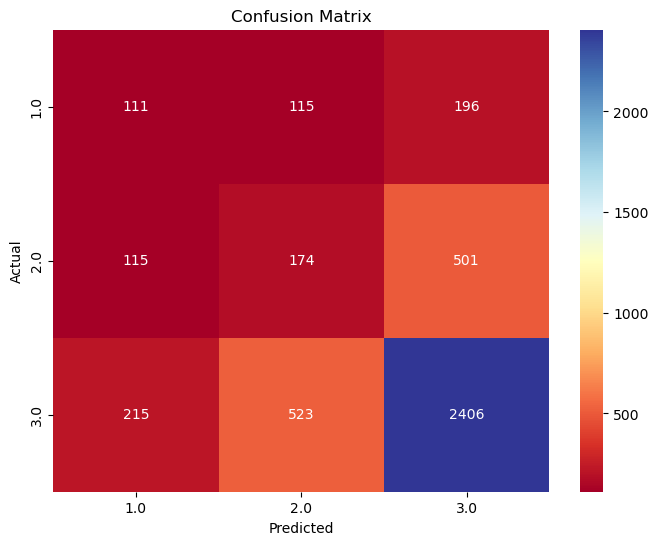

In [330]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [323]:
X = df[['level', 'sentiment_score', 'star_count']]
y = df['gpa_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

k = 147
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

knn_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", knn_accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.7247474747474747
              precision    recall  f1-score   support

         1.0       0.41      0.21      0.28       422
         2.0       0.41      0.02      0.04       790
         3.0       0.74      0.97      0.84      3144

    accuracy                           0.72      4356
   macro avg       0.52      0.40      0.39      4356
weighted avg       0.65      0.72      0.64      4356



**It's noteworthy how the KNN model performs comparably well to the Logistic Regression Model, accurately classifying a similar number of points. However, one limitation of this result is that the KNN model, being a lazy learner, might not be ideal in this context. Additionally, Logistic Regression generally handles class imbalances better by updating the coefficients assigned to each feature, which is a capability that the KNN model lacks.**

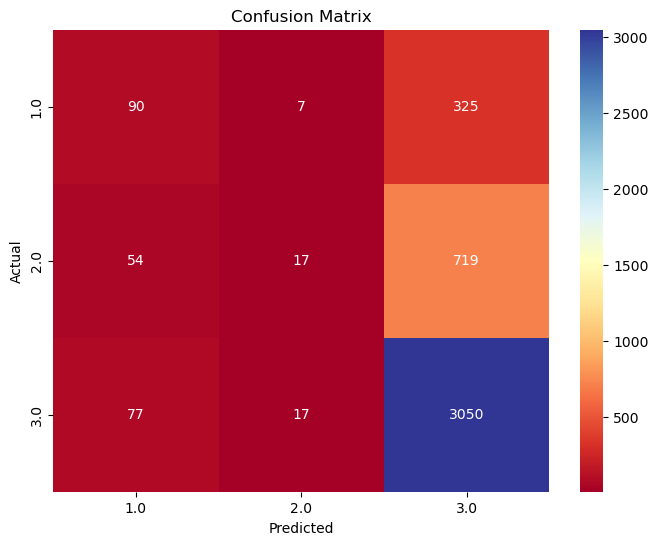

In [324]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [325]:
X = df[['level', 'sentiment_score', 'star_count']]
y = df['gpa_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, y_train)

y_pred = dtc_model.predict(X_test)

dtc_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", dtc_accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.6177685950413223
              precision    recall  f1-score   support

         1.0       0.25      0.26      0.26       422
         2.0       0.21      0.22      0.22       790
         3.0       0.78      0.77      0.77      3144

    accuracy                           0.62      4356
   macro avg       0.41      0.42      0.41      4356
weighted avg       0.62      0.62      0.62      4356



The Decision Tree Model performs well, predicting GPA categories with an accuracy of 62%. However, it falls short compared to the Logistic Regression model. A significant reason for this is the bias that develops in our model due to class imbalance, similar to what occurs with the Random Forest model. As a result, there is a higher classification rate for category 3 compared to other categories.

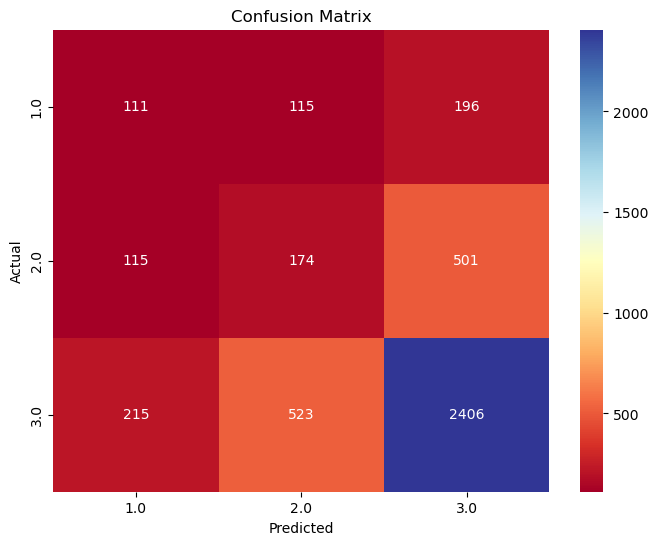

In [326]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlBu', xticklabels=dtc_model.classes_, yticklabels=dtc_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## #5 Visualization

The following graph provides a breakdown and analysis of all the models utilized in part 4.b:

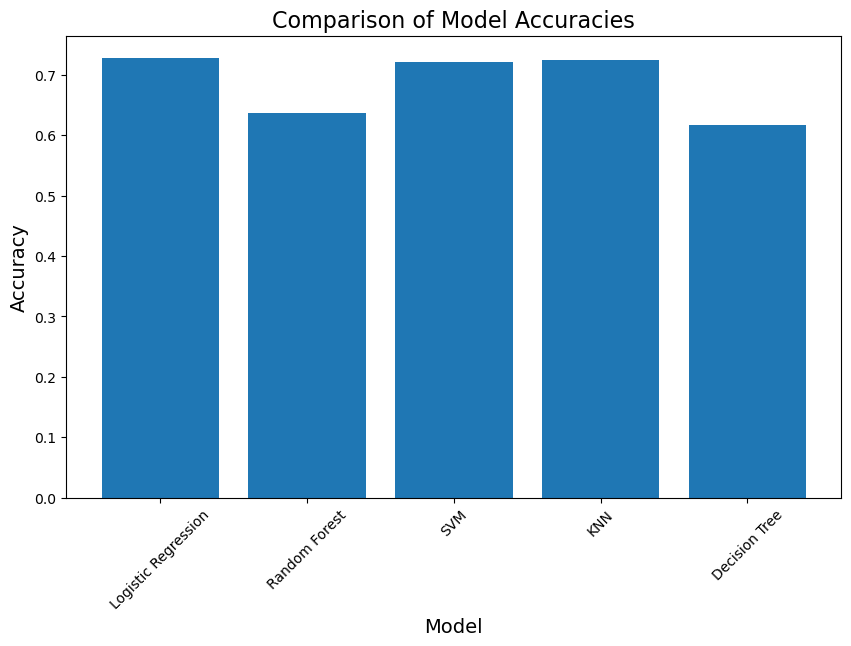

In [327]:
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'KNN', 'Decision Tree']
accuracies = [log_accuracy, randForest_accuracy, svm_accuracy, knn_accuracy, dtc_accuracy]

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Comparison of Model Accuracies', fontsize=16)
plt.xticks(rotation=45)
plt.show()

It is clear that all of the models relatively very high accuracies, with logistic regression, SVM, and KNN in the lead.

**Taking all results into consideration, it is appropriate to conclude that the logistic regression model is the most suitable for our classification task. It can handle class imbalances better than other models and has accurately predicted a greater number of GPA categories compared to the other models.**

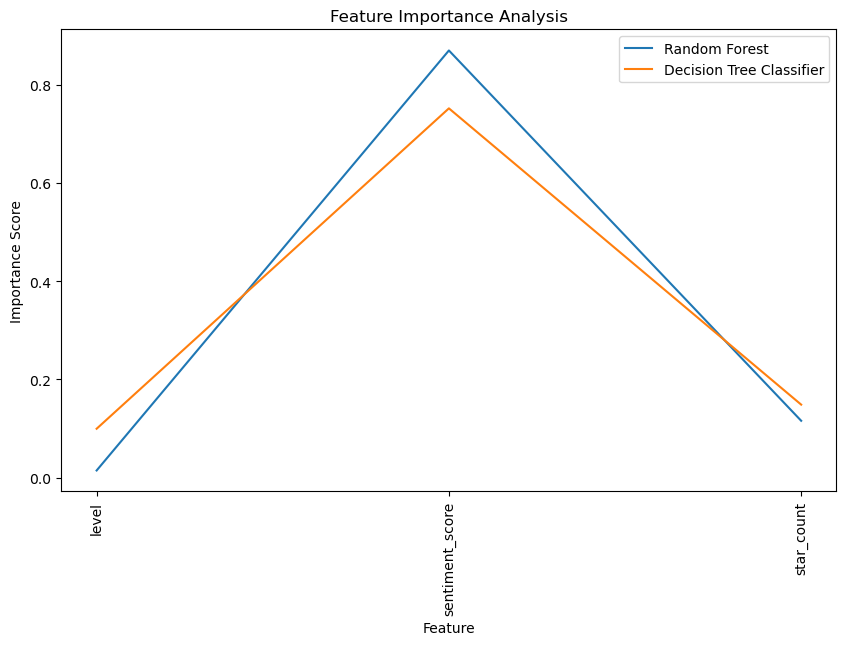

In [328]:
# Assuming you have fitted models: randForest_model, dtc_model, log_model
models = {'Random Forest': randForest_model, 'Decision Tree Classifier': dtc_model, 'Logistic Regression': log_model, 'Support Vector Machine':svm_model, 'KNN': knn_model}

plt.figure(figsize=(10, 6))
for model_name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        plt.plot(model.feature_importances_, label=model_name)

plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.title('Feature Importance Analysis')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.legend()
plt.show()

Only the Random Forest and Decision Tree Classifier models typically have this feature importance attribute, as they inherently compute feature importances during their training process.

## #6 Insights and Conclusion:

##### Collection
Our process for collecting the data was rewarding. We took advantage of the opportunity to practice web-scraping by gathering the planetterp review data that was not readily available through the API.

##### In our initial exploration, we concluded:
- there is a significant difference in the ratings left by students expecting an A grade, than from those that are expecting less than an A grade
- there is a significant difference in mean GPA across different levels of CS courses with the passage of time
- ratings from anonymous accounts tend to be different than those from non-anonymous acounts

##### ML Methods:
Depending on the use case, a classifier that only performs well on the extreme cases may be acceptable, but this also raises a couple questions to investigate if we were to continue with this data:
- Our target variable star-rating is an ordinal variable, so not quite continuous, but also not discrete classes--this left our model selection and building process as a bit of an open question.
- The uneven representation of our data may be negatively influencing our results. We have significantly more 5 star reviews than any other rating, and we would investigate how to account for this in further analysis.
- Similarly, the number of data points clustered within the GPA_CATEGORY 3.0 was extremely high compared to other categories. Despite attempts to distribute the data across different percentiles, the result remained unchanged. Therefore, we have currently selected arbitrary range values that best represent the analysis we intend to perform. This class imbalance also has direct influence on the recommended models.
- For more accurate predictions regarding whether a student should take a course or not, it would be immensely helpful to have data pertaining to a given student's GPA at the time of their review. This is a critical feature we feel is currently missing from the dataset and could provide significant value for course recommendations.
- Currently, all the reviews for a given course represent a combination of student views not specific to the course but also the professor. This can impact the student_sentiment_score calculations, as the score would be affected depending on which of these two factors receives more emphasis.

##### Reader Insights:
An uninformed reader would feel more informed about the topic because we have outlined the specifics of the dataset, provided initial analysis, and extensively explained our ML models. The detailed description of the dataset, including its sources and key variables, offers readers a comprehensive understanding of the data under analysis. Additionally, our initial analysis delves into the dataset's characteristics, revealing insights such as trends, patterns, and potential outliers. This introductory exploration serves as a valuable foundation for readers new to the topic, enabling them to grasp the dataset's nuances and context.

Moreover, our thorough explanation of machine learning models applied to the dataset enhances readers' understanding of the analytical process. By outlining the objectives, methodologies, and performance metrics of each model, we demystify complex concepts and empower readers to comprehend the intricacies of predictive modeling.

For readers already familiar with the topic, our project offers a wealth of additional insights and learning opportunities. Beyond model implementation, we provide nuanced interpretations of model results and their implications for the underlying data. By contextualizing our findings within the broader landscape of the topic, we enable informed readers to glean new perspectives and actionable insights.

In conclusion, our project not only informs uninformed readers about the topic but also enriches the understanding of informed readers by offering fresh insights and perspectives.

## # Final Thoughts:

It's possible to have fun with data science. Consider the following graph: 😁

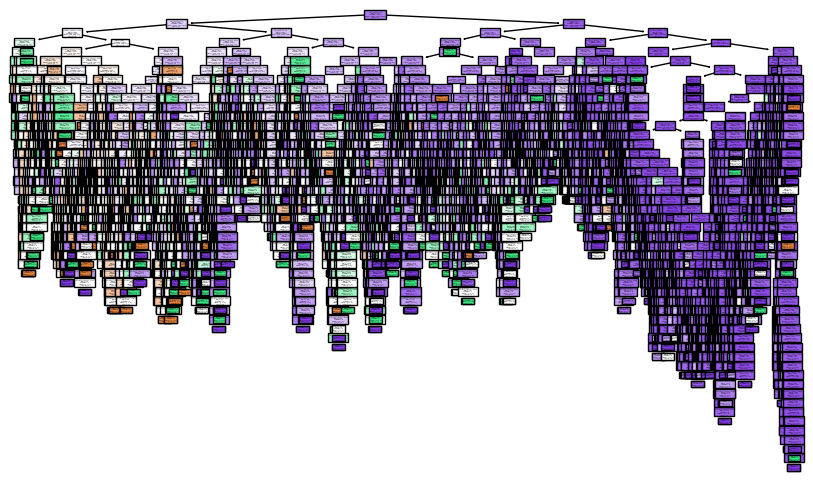

In [329]:
# Converting class labels to string representations
class_names_str = [str(label) for label in y.unique()]

plt.figure(figsize=(10, 6))
plot_tree(dtc_model, filled=True, feature_names=X.columns, class_names=class_names_str)
plt.show()

This is the visual representation of our decision tree classifier model.

If you can read the text on the nodes, we'll nominate you for the Nobel Peace Prize. :)